In [37]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [38]:
def read_and_preprocess(file_path, event_code, target_date_str):
    df = pd.read_csv(file_path, header=1)
    df['Created Date'] = pd.to_datetime(df['Created Date'], dayfirst=True)
    df['Event'] = event_code
    target_date = pd.to_datetime(target_date_str, dayfirst=True)
    df['T_minus'] = (target_date - df['Created Date']).dt.days
    return df

In [39]:
def combine_datasets(*datasets):
    return pd.concat(datasets, ignore_index=True)


In [40]:
def plot_registrations_countdown(combined_data,tile):
    t_minus_registrations = combined_data.groupby('T_minus').size()
    plt.figure(figsize=(20, 6))
    plt.plot(t_minus_registrations.index, t_minus_registrations.values, marker='o', linestyle='-', color='b')
    plt.title(tile)
    plt.xlabel('Days Until Event (T-minus)')
    plt.ylabel('Number of Registrations')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [41]:
def calculate_daily_registrations(combined_data):
    daily_registrations = combined_data.groupby('Created Date').size().reset_index(name='Total Registrations')
    daily_registrations['Z-Score'] = (daily_registrations['Total Registrations'] - daily_registrations['Total Registrations'].mean()) / daily_registrations['Total Registrations'].std()
    daily_registrations['Advertisement'] = (daily_registrations['Z-Score'] > 1).astype(int)
    return daily_registrations

In [42]:
def prepare_for_forecasting(daily_registrations):
    first_date = daily_registrations['Created Date'].min()
    last_date = daily_registrations['Created Date'].max()
    date_range = pd.DataFrame(pd.date_range(start=first_date, end=last_date), columns=['Date'])
    complete_reg = pd.merge(date_range, daily_registrations, left_on='Date', right_on='Created Date', how='left', sort=True)
    complete_reg.drop(columns=['Created Date'], inplace=True)
    complete_reg['Total Registrations'].fillna(0, inplace=True)
    complete_reg['Z-Score'].fillna(0, inplace=True)
    complete_reg['Advertisement'].fillna(0, inplace=True)
    complete_reg['Date'] = pd.to_datetime(complete_reg['Date'])
    complete_reg = complete_reg.set_index('Date')
    return complete_reg


In [43]:
def split_data_for_forecasting(complete_reg, split_ratio=0.8):
    train_size = int(len(complete_reg) * split_ratio)
    train = complete_reg.iloc[:train_size]
    test = complete_reg.iloc[train_size:]

    train_endog = train['Total Registrations']
    train_exog = train[['Advertisement']]
    test_endog = test['Total Registrations']
    test_exog = test[['Advertisement']]

    return train_endog, train_exog, test_endog, test_exog

def auto_arima_forecasting(endog, exog):
    auto_model = auto_arima(endog, exogenous=exog, seasonal=True, m=7, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True)
    print(auto_model.summary())
    return auto_model.order, auto_model.seasonal_order

def sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order):
    model = SARIMAX(train_endog, order=order, seasonal_order=seasonal_order, exog=train_exog)
    results = model.fit()
    print(results.summary())
    forecast_results = results.get_forecast(steps=len(test_exog), exog=test_exog)
    return forecast_results.predicted_mean, forecast_results.conf_int()


In [44]:
def plot_forecast_vs_actuals(train, test, forecast_values, conf_int):
    
    # Plotting
    plt.figure(figsize=(30, 6))

    # Plot the observed values
    plt.plot(train.index, train['Total Registrations'], label='Train', color='blue')
    plt.plot(test.index, test['Total Registrations'], label='Test', color='green')

    # Plot the forecasted values
    plt.plot(test.index, forecast_values, label='Forecast', color='red')

    # Plot the confidence interval
    plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Total Registrations')
    plt.title('SARIMAX Model Forecast vs Actuals')
    plt.legend()
    plt.show()


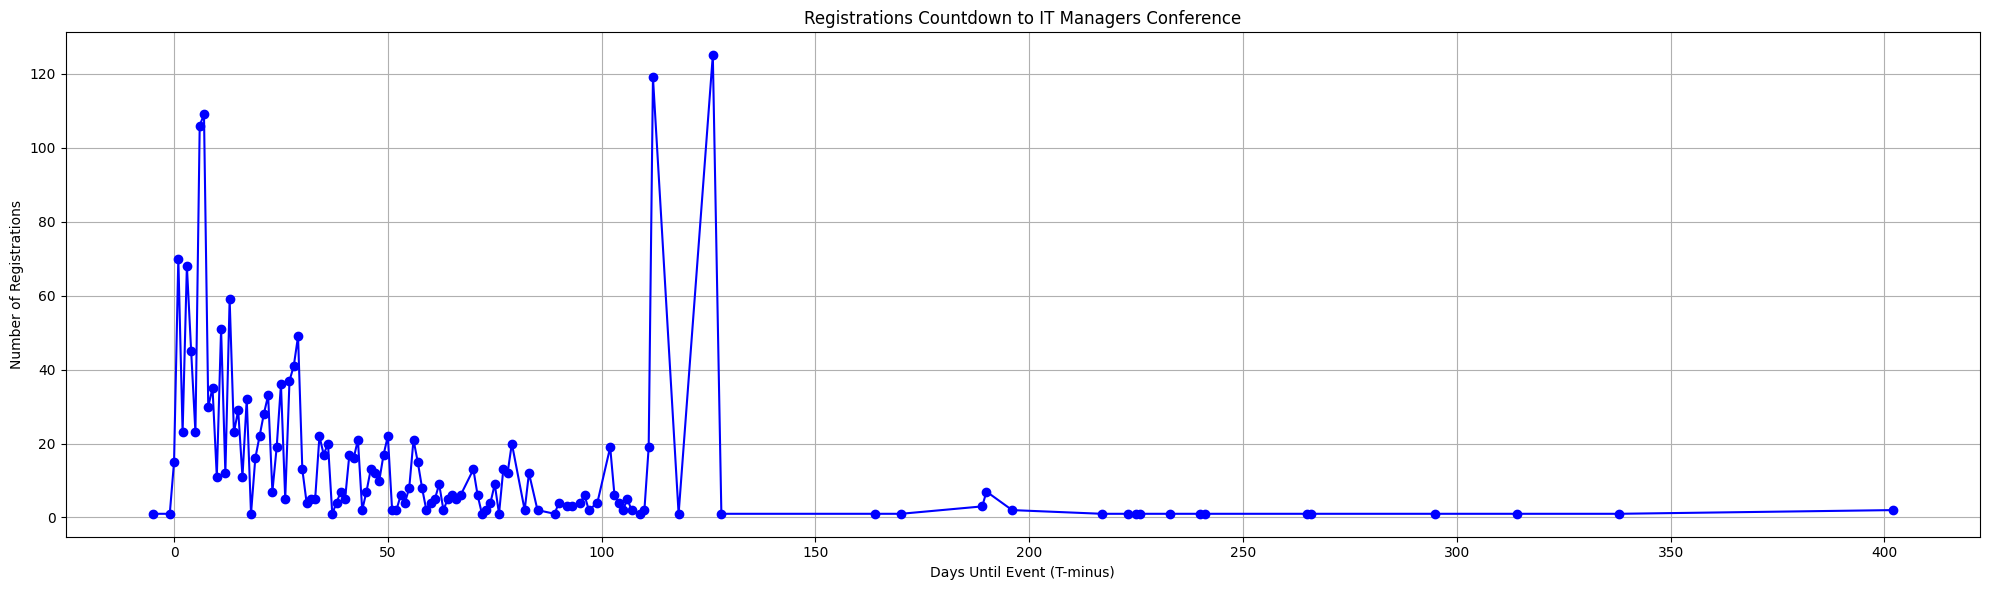

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5241.894, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5144.259, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5036.145, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5240.118, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=5035.345, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=5035.091, Time=0.17 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=4932.088, Time=0.46 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=4930.687, Time=0.57 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=4992.586, Time=0.48 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=4932.664, Time=0.75 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=4940.429, Time=0.65 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=5155.032, Time=0.51 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(0,1,2)(2,0,1)[7] intercept   : AIC=i

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                Total Registrations   No. Observations:                  706
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 7)   Log Likelihood               -1989.003
Date:                            Tue, 20 Feb 2024   AIC                           3990.007
Time:                                    15:36:29   BIC                           4017.356
Sample:                                07-16-2019   HQIC                          4000.575
                                     - 06-20-2021                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Advertisement    58.8809      0.341    172.564      0.000      58.212      59.550
ar.L1             0.2237  

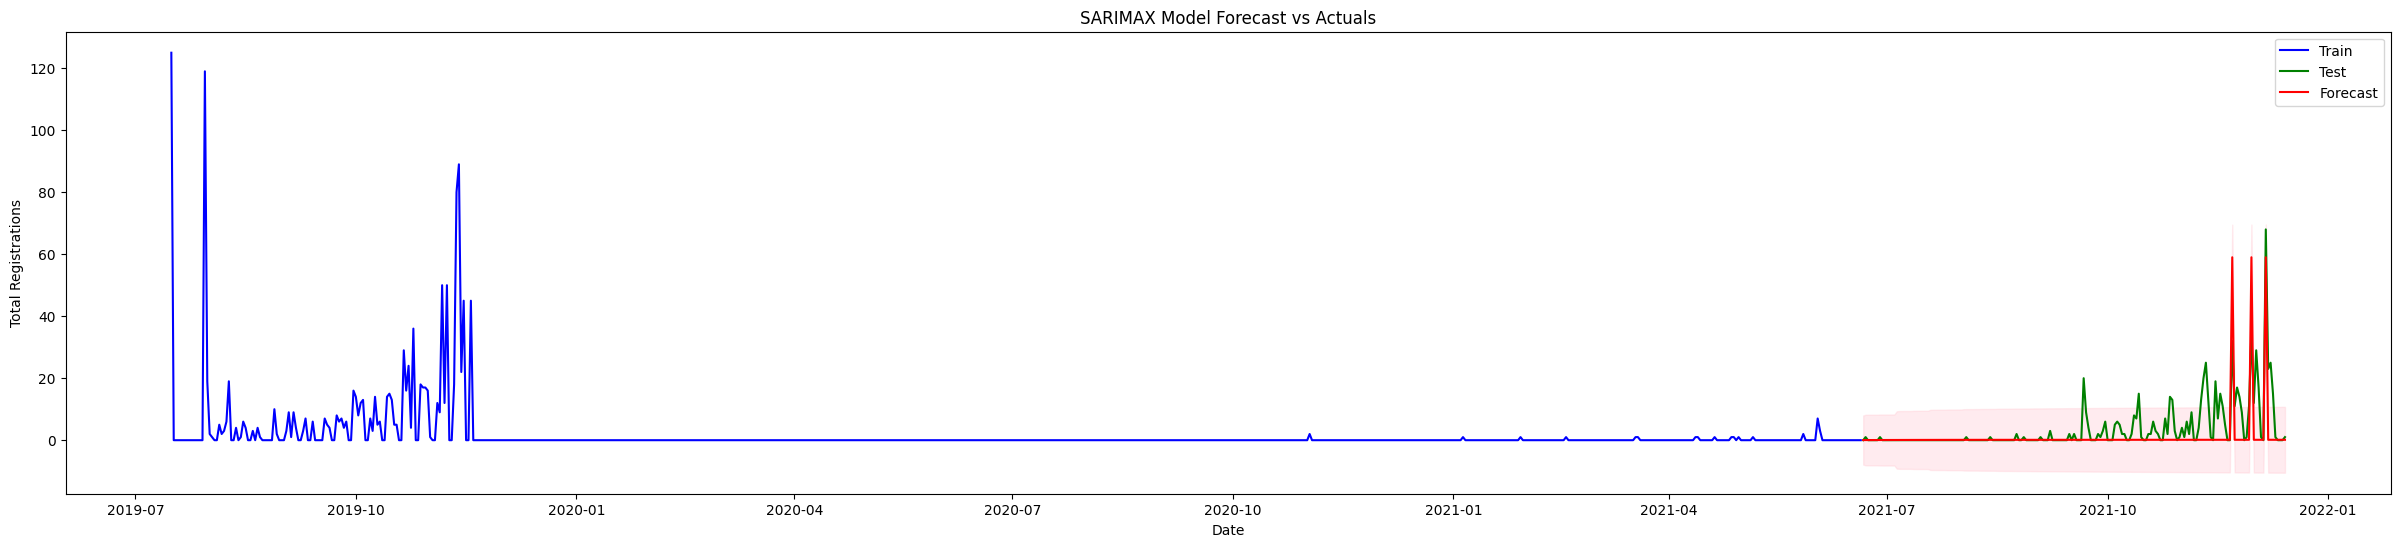

In [45]:
# D19 & D21
d19 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\D19.csv", 'D19', '19/11/2019')
d21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\D21.csv", 'D21', '09/12/2021')

# Combine datasets
combined_it_managers = combine_datasets(d19, d21)

# Proceed with analysis and plotting
plot_registrations_countdown(combined_it_managers, 'Registrations Countdown to IT Managers Conference')
daily_registrations_it = calculate_daily_registrations(combined_it_managers)
complete_reg_it = prepare_for_forecasting(daily_registrations_it)

# Split the data into training and testing sets
train_endog, train_exog, test_endog, test_exog = split_data_for_forecasting(complete_reg_it)

# Use Auto ARIMA to find the optimal SARIMAX parameters
order, seasonal_order = auto_arima_forecasting(train_endog, train_exog)

# Fit the SARIMAX model using the optimal parameters
forecast_values, conf_int = sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order)

test_df = test_exog.copy()
test_df['Total Registrations'] = test_endog.values

# Plot the forecast against actual values
plot_forecast_vs_actuals(complete_reg_it.iloc[:len(train_endog)], test_df, forecast_values, conf_int)


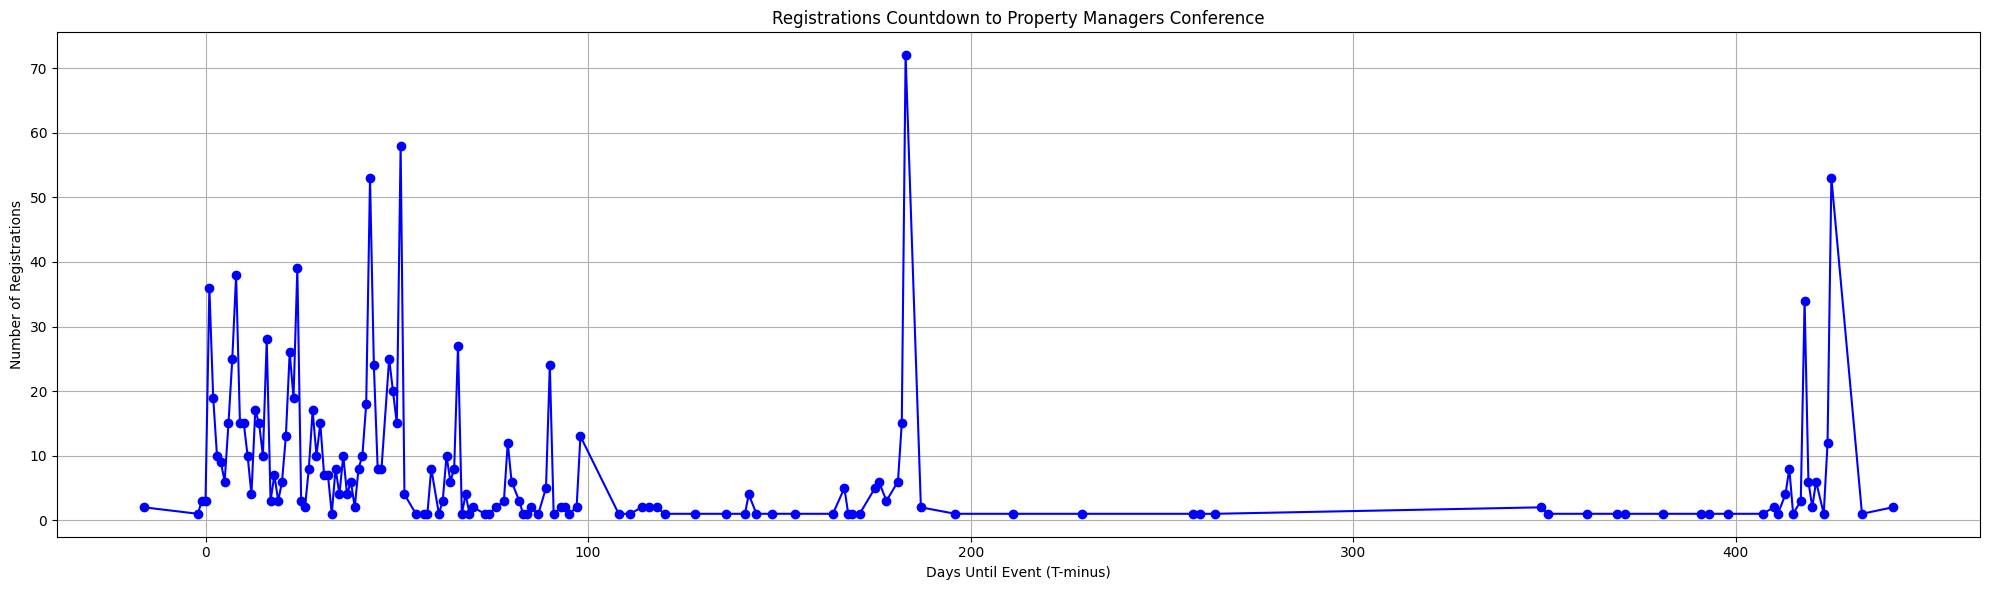

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=3393.565, Time=1.61 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3624.490, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3532.355, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3412.645, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3622.490, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=3395.634, Time=0.90 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=3394.503, Time=0.81 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=3393.639, Time=2.50 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=3393.219, Time=2.11 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=3397.176, Time=1.27 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=3391.950, Time=2.51 sec
 ARIMA(1,1,2)(2,0,2)[7] intercept   : AIC=3390.075, Time=2.14 sec
 ARIMA(1,1,2)(1,0,2)[7] intercept   : AIC=3391.518, Time=2.13 sec
 ARIMA(1,1,2)(2,0,1)[7] intercept   : AIC=3391.873, Time=1.53 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:                    Total Registrations   No. Observations:                  527
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -1397.051
Date:                                Tue, 20 Feb 2024   AIC                           2810.102
Time:                                        15:37:17   BIC                           2844.224
Sample:                                    02-06-2020   HQIC                          2823.462
                                         - 07-16-2021                                         
Covariance Type:                                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Advertisement    31.4070      0.329     95.366      0.000      30.762      3

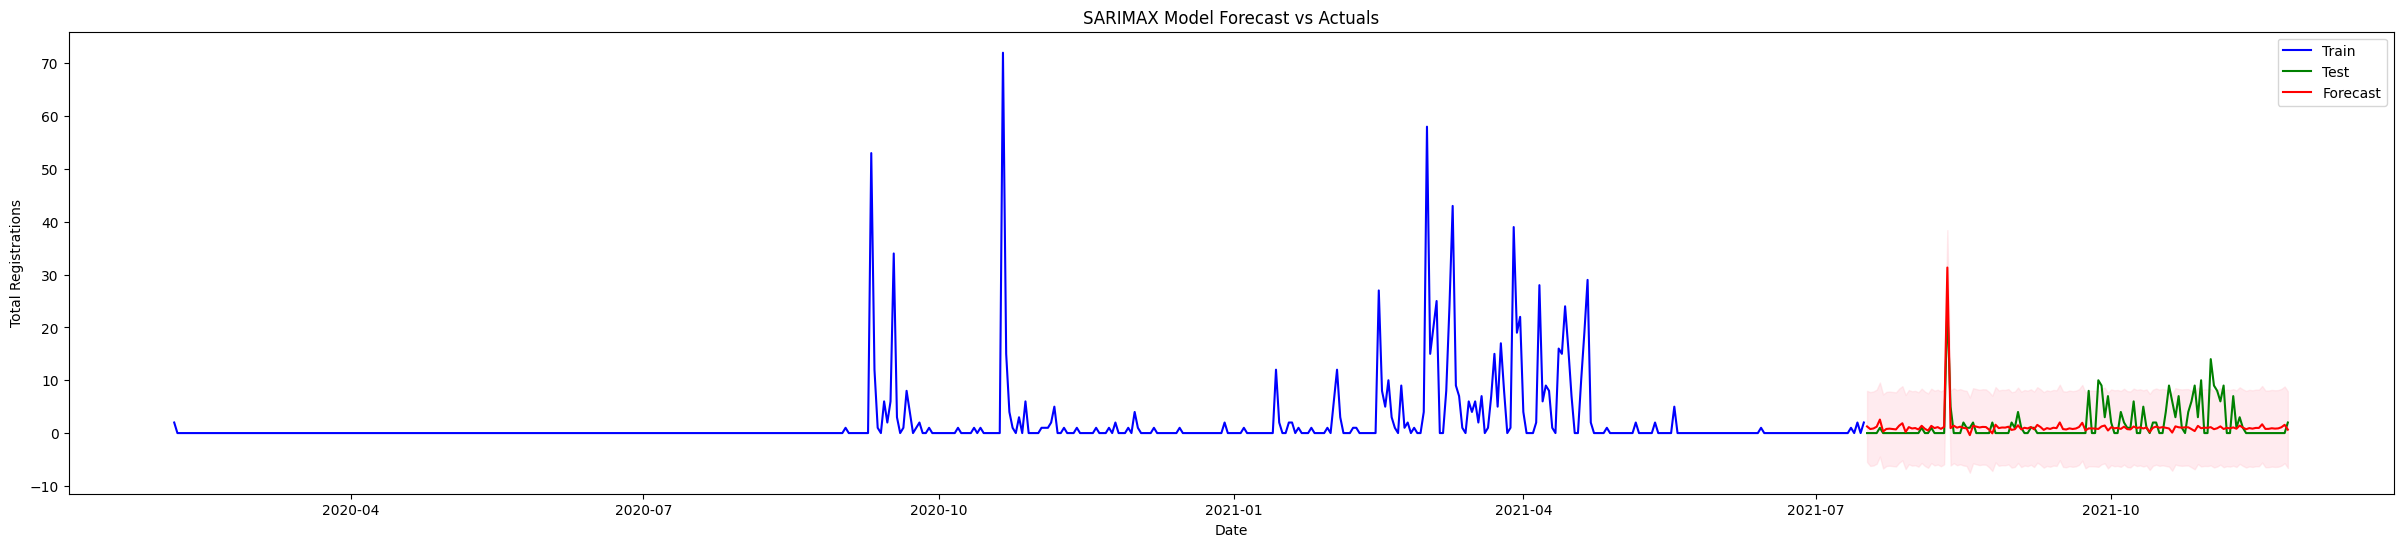

In [46]:
# GP21 and NP21
gp21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\GP21.csv", 'GP21', '22/04/2021')
np21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\NP21.csv", 'NP21', '09/11/2021')

# Combine datasets
combined_property_managers = combine_datasets(gp21, np21)

# Proceed with analysis and plotting
plot_registrations_countdown(combined_property_managers, 'Registrations Countdown to Property Managers Conference')
daily_registrations_prop = calculate_daily_registrations(combined_property_managers)
complete_reg_prop = prepare_for_forecasting(daily_registrations_prop)

# Split the data into training and testing sets
train_endog, train_exog, test_endog, test_exog = split_data_for_forecasting(complete_reg_prop)

# Use Auto ARIMA to find the optimal SARIMAX parameters
order, seasonal_order = auto_arima_forecasting(train_endog, train_exog)

# Fit the SARIMAX model using the optimal parameters
forecast_values, conf_int = sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order)

test_df = test_exog.copy()
test_df['Total Registrations'] = test_endog.values

# Plot the forecast against actual values
plot_forecast_vs_actuals(complete_reg_prop.iloc[:len(train_endog)], test_df, forecast_values, conf_int)


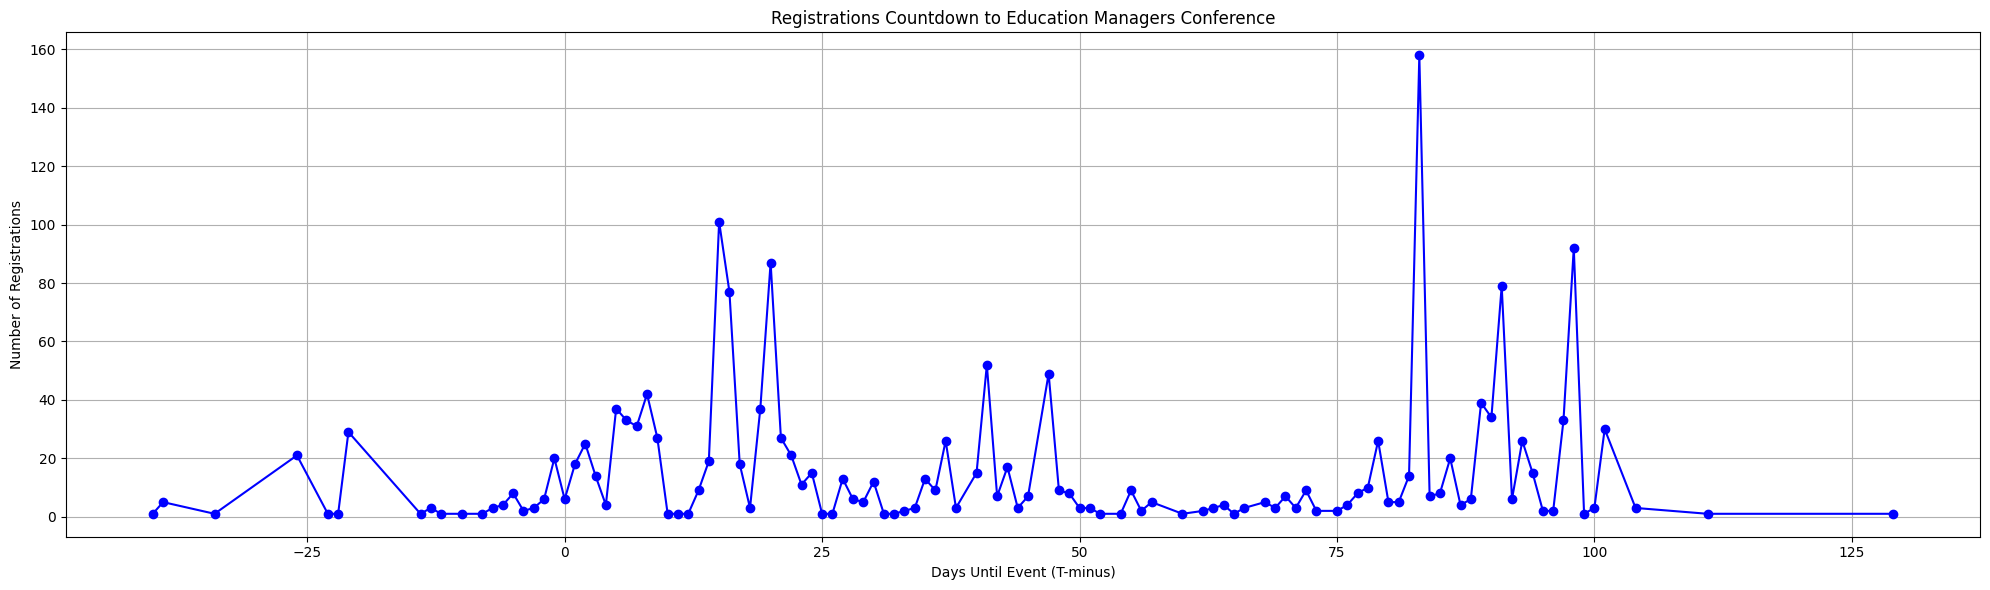

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=3034.471, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3219.312, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3155.254, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3033.884, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3217.369, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3031.898, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=3033.884, Time=0.19 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=3028.142, Time=0.70 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=3027.241, Time=0.96 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=3035.883, Time=0.36 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=3022.385, Time=2.29 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=3026.483, Time=1.01 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=3032.138, Time=1.13 sec
 ARIMA(0,1,2)(2,0,2)[7] intercept   : 

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:                    Total Registrations   No. Observations:                  392
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -1326.476
Date:                                Tue, 20 Feb 2024   AIC                           2666.952
Time:                                        15:37:35   BIC                           2694.733
Sample:                                    03-16-2022   HQIC                          2677.963
                                         - 04-11-2023                                         
Covariance Type:                                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Advertisement    50.6749      0.839     60.370      0.000      49.030      5

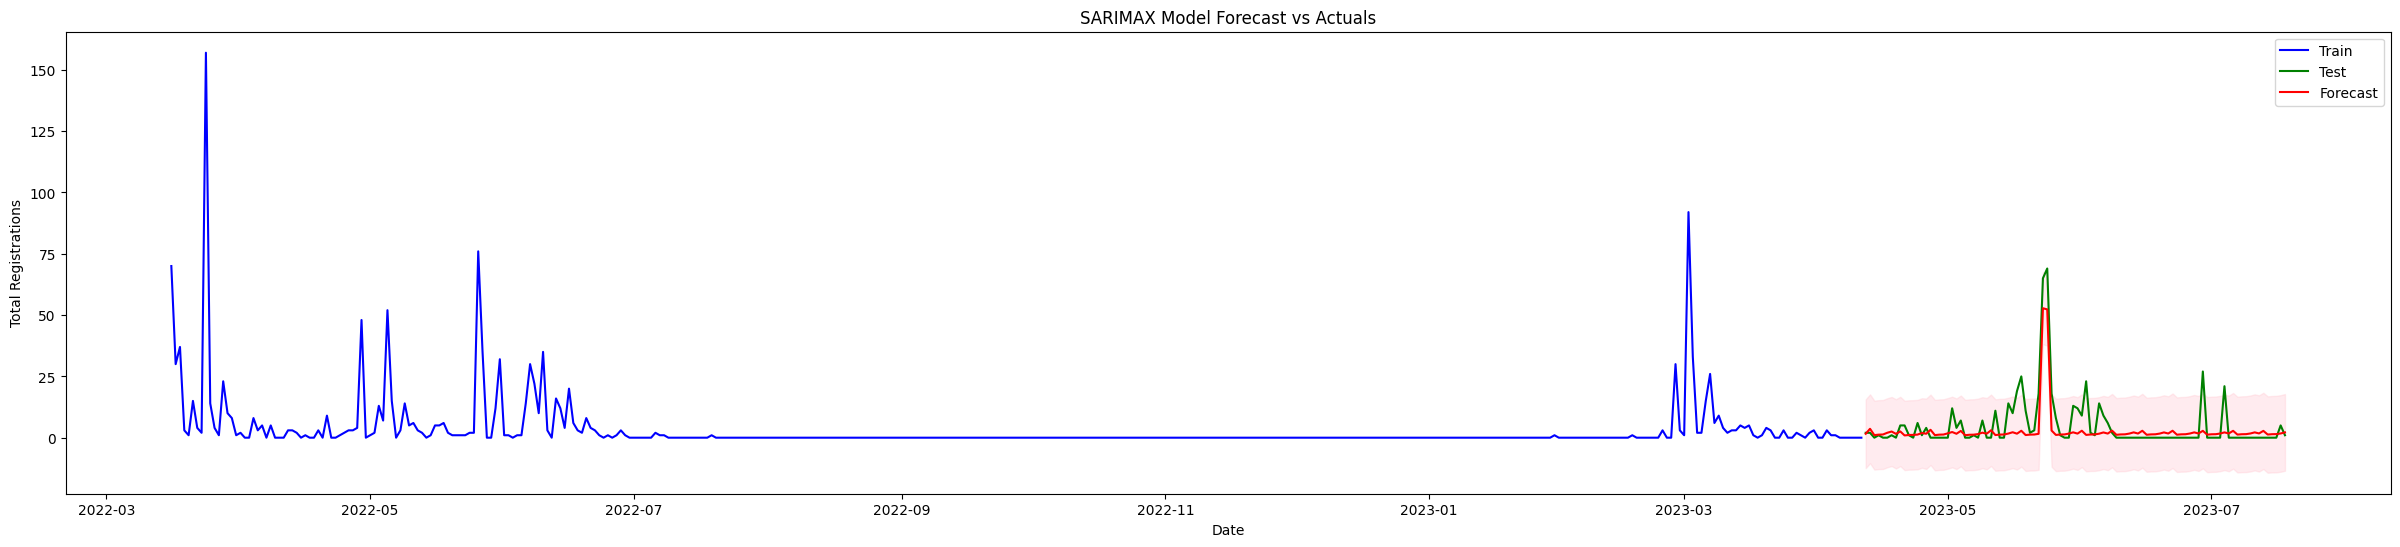

In [47]:
# SRM22 and SRM23
srm22 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\SRM22.csv", 'SRM22', '15/06/2022')
srm23 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\SRM23.csv", 'SRM23', '08/06/2023')

# Combine datasets
combined_ed_managers = combine_datasets(srm22, srm23)

# Proceed with analysis and plotting
plot_registrations_countdown(combined_ed_managers, 'Registrations Countdown to Education Managers Conference')
daily_registrations_ed = calculate_daily_registrations(combined_ed_managers)
complete_reg_ed = prepare_for_forecasting(daily_registrations_ed)

# Split the data into training and testing sets
train_endog, train_exog, test_endog, test_exog = split_data_for_forecasting(complete_reg_ed)

# Use Auto ARIMA to find the optimal SARIMAX parameters
order, seasonal_order = auto_arima_forecasting(train_endog, train_exog)

# Fit the SARIMAX model using the optimal parameters
forecast_values, conf_int = sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order)

test_df = test_exog.copy()
test_df['Total Registrations'] = test_endog.values

# Plot the forecast against actual values
plot_forecast_vs_actuals(complete_reg_ed.iloc[:len(train_endog)], test_df, forecast_values, conf_int)
